# Modelling Antibiotics Resistance through virtual simulations
Authors: Talhah Peerbhai (talhah@cmu.edu), Hanna Qasim (hqasim@andrew.cmu.edu)

49.79411910783112


/var/folders/87/d5l9b5f52ml6sfqqmvcwv0jr0000gn/T/ipykernel_1843/3519593052.py:80: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  nutrient_layer = PropertyLayer("nutrient",self.width,self.height,default_value=0)


[Text(0.5, 1.0, 'Nutrient distribution')]

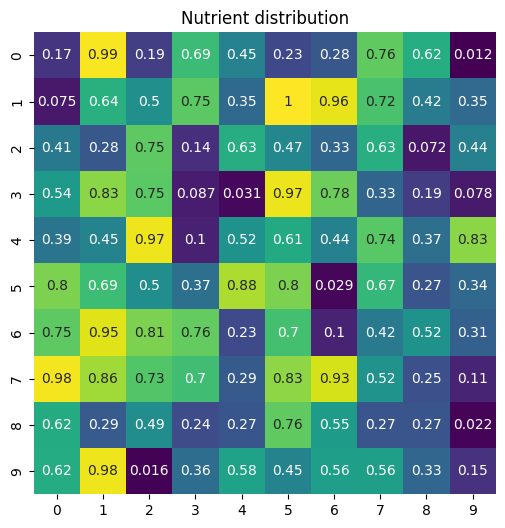

In [20]:
import mesa
from mesa.space import PropertyLayer
import seaborn as sns
import numpy as np 
from mesa import DataCollector

class BacteriaAgent(mesa.Agent):
    def __init__(self, unique_id, model, uptake_rate, initial_size, initial_biomass, biomass_threshold):
        super().__init__(unique_id, model)
        self.uptake_rate = uptake_rate
        self.size = initial_size
        self.biomass = initial_biomass
        self.split_threshold = 2 * initial_size  # Bacteria splits when its size has doubled
        self.biomass_threshold = biomass_threshold
    
    def step(self):
        # self.uptake_nutrient()
        self.grow()
        if self.ready_to_split():
            self.split()

    def grow(self):
        # Get the nutrient uptake
        nutrient_uptake = self.uptake_nutrient()
        # Increase the size based on the nutrient uptake
        self.size += nutrient_uptake
        # Update biomass
        self.biomass = self.size * 1.5 # Assume a constant conversion factor of 1.5 (this is an arbitary number for now)

    def ready_to_split(self):
        # Bacteria is ready to split if its size is greater than the split 
        # threshold and the environment can support more biomass
        return self.size >= self.split_threshold and self.model.total_biomass() < self.model.biomass_threshold
    
    def split(self):
        # Create a new bacterium with half the size and biomass of the current one
        new_bacteria = BacteriaAgent(self.model.next_id(), self.model, self.uptake_rate, self.size / 2, self.biomass / 2, self.biomass_threshold)
        self.model.schedule.add(new_bacteria)
        self.model.grid.place_agent(new_bacteria, self.pos)
        # Halve the size and weight of the current bacterium
        self.size /= 2
        self.biomass /= 2

    def uptake_nutrient(self):
        # Get the current cell of the bacterium
        x, y = self.pos
        # Get the current nutrient level in this cell
        nutrient = self.model.grid.properties["nutrient"].data[x][y]
        # Uptake only the available nutrients
        # Subtract the uptaken nutrients from the nutrient level in the cell
        self.model.grid.properties["nutrient"].data[x][y] -= min(self.uptake_rate * nutrient, nutrient)
        return nutrient
        # return min(self.uptake_rate * nutrient, nutrient)

class SimModel(mesa.Model):
    def __init__(self, params):
        super().__init__()
        self.width = params["width"]
        self.height = params["height"]
        self.diffusion_coefficient = params["diffusion_coefficient"]
        self.num_agents = params["num_agents"]
        self.uptake_rate = params["uptake_rate"]
        # lag_phase = params["lag_phase"] # idk what to do with this
        self.initial_size = params["initial_size"]
        self.initial_biomass = params["initial_biomass"]
        # division_rate = params["division_rate"]
        self.biomass_threshold = params["biomass_threshold"]

        # To visualize the biomass, bacteria count and size
        self.datacollector = DataCollector(
            {
                "Total Biomass": lambda m: m.total_biomass(),
                "Bacteria Count": lambda m: m.schedule.get_agent_count(),
                "Average Size": lambda m: sum(agent.size for agent in m.schedule.agents) / m.schedule.get_agent_count(),
            }
        )

        # Initialize Grid Properties
        self.grid = mesa.space.MultiGrid(self.width,self.height,True)
        nutrient_layer = PropertyLayer("nutrient",self.width,self.height,default_value=0)
        nutrient_layer.modify_cells(lambda x: np.random.random())
        self.grid.add_property_layer(nutrient_layer)
        
        # Initialize Scheduler
        self.schedule = mesa.time.RandomActivation(self)
       
        # Initialize Agents
        for i in range(self.num_agents):
            # a = BacteriaAgent(i,self, uptake_rate, initial_size, initial_biomass, biomass_threshold)
            a = BacteriaAgent(i, self, params['uptake_rate'], params['initial_size'], params['initial_biomass'], params['biomass_threshold'])
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
    
    def step(self):
        self.schedule.step()
        # Vectorized version should have a major speedup
        # Runtime went from 75 seconds to 5 seconds for 1000 steps
        #self.diffuse_nutrients_vectorized()
        self.diffuse_nutrients()
        self.total_biomass()

        # To visualize the biomass, bacteria count and size
        self.datacollector.collect(self)

    def total_biomass(self):
        total_biomass = 0
        for agent in self.schedule.agents:
            total_biomass += agent.biomass
        return total_biomass
        
    def diffuse_nutrients(self):
        new_nutrient_distribution = np.copy(self.grid.properties["nutrient"].data)
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0: continue  # Skip self
                        x2 = (x + dx) % self.grid.width
                        y2 = (y + dy) % self.grid.height
                        diff = (self.grid.properties["nutrient"].data[x2][y2] -
                                self.grid.properties["nutrient"].data[x][y])
                        if dx == 0 or dy == 0:  # Adjacent
                            transfer = diff * self.diffusion_coefficient
                        else:  # Diagonal
                            transfer = (diff * self.diffusion_coefficient) / np.sqrt(2)
                        new_nutrient_distribution[x][y] += transfer
                        new_nutrient_distribution[x2][y2] -= transfer
        
        self.grid.properties["nutrient"].data = new_nutrient_distribution

    def diffuse_nutrients_vectorized(self):
        # Extract the current nutrient grid for convenience
        nutrient_grid = self.grid.properties["nutrient"].data
        # Create padded grid to handle edge wrapping more easily
        padded = np.pad(nutrient_grid, pad_width=1, mode='wrap')
        # Calculate the diffusion from each cell to its neighbors
        # For direct neighbors
        direct_diffusion = padded[1:-1, :-2] + padded[1:-1, 2:] + padded[:-2, 1:-1] + padded[2:, 1:-1] - 4 * nutrient_grid
        # For diagonal neighbors, adjusted by 1/sqrt(2)
        diagonal_diffusion = (padded[:-2, :-2] + padded[:-2, 2:] + padded[2:, :-2] + padded[2:, 2:] - 4 * nutrient_grid) / np.sqrt(2)
        # Sum of both diffusion effects
        total_diffusion = direct_diffusion + diagonal_diffusion
        # Apply the diffusion coefficient
        nutrient_grid += total_diffusion * self.diffusion_coefficient
        # Update the nutrient grid
        self.grid.properties["nutrient"].data = nutrient_grid

        
# model = SimModel(10,10, uptake_rate=0.1)
params = {
    "width": 10,
    "height": 10,
    "diffusion_coefficient": 0.5,
    "num_agents": 10,  # arbitrary number
    "uptake_rate": 0.1,
    "initial_size": 300,  # arbitary number
    "initial_biomass": 500,  # arbitary number
    "biomass_threshold": 1000  # arbitary number
}
model = SimModel(params)
# For profiling purposes
#model2 = copy.deepcopy(model)
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["nutrient"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["nutrient"].data[x][y]
print(amount)
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(6, 6)
g.set(title="Nutrient distribution")


49.391597217589386


[Text(0.5, 1.0, 'Nutrient distribution')]

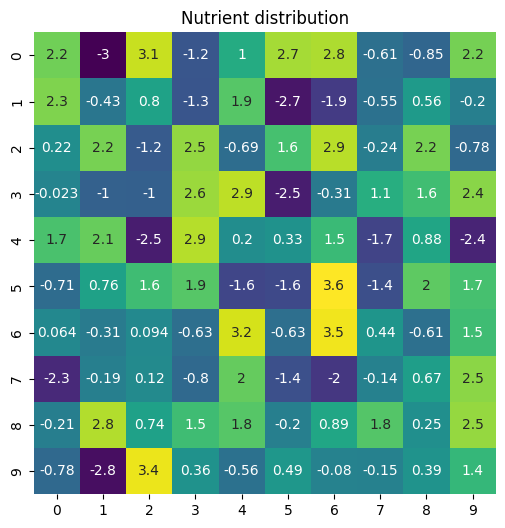

In [21]:
for _ in range(1):
    model.step()
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["nutrient"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["nutrient"].data[x][y]
print(amount)
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(6, 6)
g.set(title="Nutrient distribution")

[Text(0.5, 1.0, 'Agent Dis')]

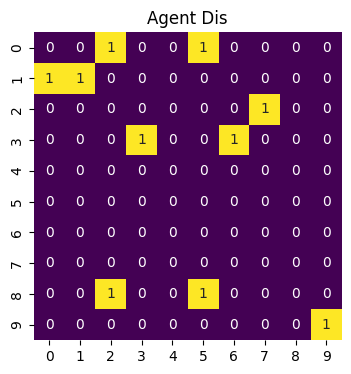

In [22]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
f = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
f.figure.set_size_inches(4, 4)
f.set(title="Agent Dis")

Testing if uptake_nutrient function is working: Note that there is a decrease in nutrient levels in the cells where the bacteria agents are located

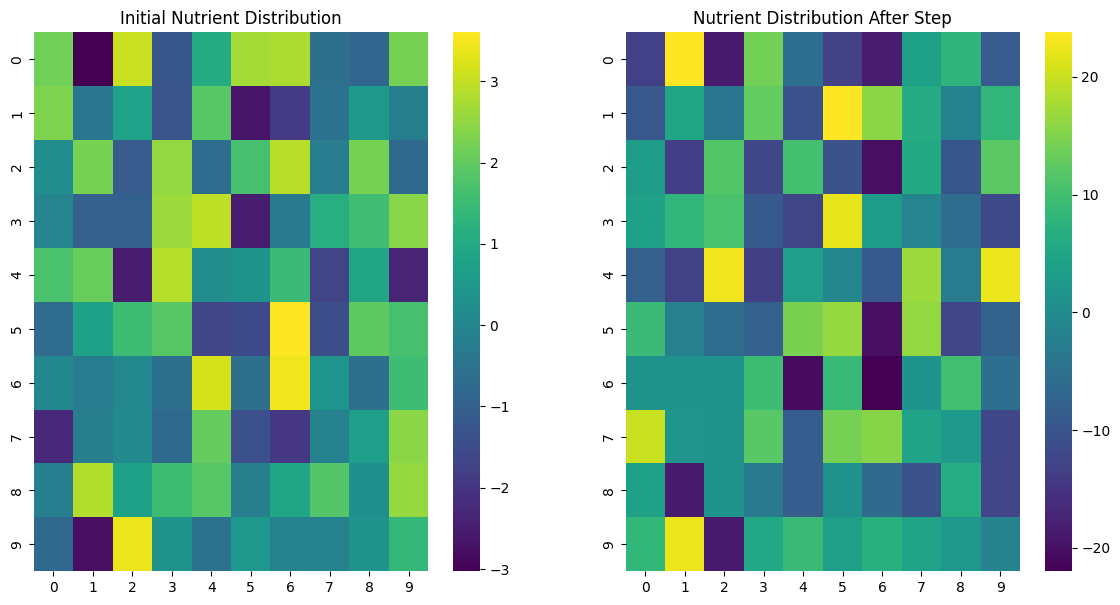

In [23]:
import matplotlib.pyplot as plt

# Create the model
# model = SimModel(50, 50, uptake_rate=0.1)

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot the initial nutrient distribution
sns.heatmap(model.grid.properties["nutrient"].data, cmap="viridis", ax=axs[0])
axs[0].set_title("Initial Nutrient Distribution")

# Run the model step
model.step()

# Plot the nutrient distribution after running the model step
sns.heatmap(model.grid.properties["nutrient"].data, cmap="viridis", ax=axs[1])
axs[1].set_title("Nutrient Distribution After Step")

# Show the figure
plt.show()

Visualizing Change in Biomass, Bacteria Count and Size

Ideally:
- Total biomass should increase over time as the bacteria grows and divide
- Bacteria count should also genreally increase over time, as each bacteria results in more bacteria
- Average Size ...


/var/folders/87/d5l9b5f52ml6sfqqmvcwv0jr0000gn/T/ipykernel_1843/3519593052.py:80: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  nutrient_layer = PropertyLayer("nutrient",self.width,self.height,default_value=0)


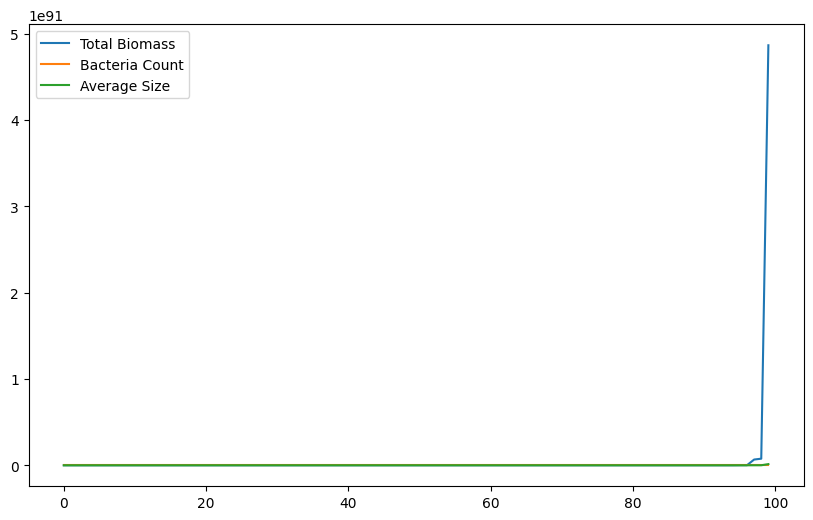

In [24]:
model = SimModel(params)
for i in range(100):  # Run for 100 steps
    model.step()

data = model.datacollector.get_model_vars_dataframe()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data["Total Biomass"], label="Total Biomass")
plt.plot(data["Bacteria Count"], label="Bacteria Count")
plt.plot(data["Average Size"], label="Average Size")
plt.legend()
plt.show()